WNixalo | 20181124

---

This notebook is an attempt to breach a score of 0.93 on the private leaderboard using ResNet34, using a more aggressive learning rates.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
__version__ # fastai

'1.0.28'

## Data

In [3]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True); #path

In [4]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [5]:
np.random.seed(0)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' '))
data = (src.transform(tfms, size=128)
       .databunch()
       .normalize(imagenet_stats))

In [6]:
arch = models.resnet34
acc_025 = partial(accuracy_thresh, thresh=0.25)
f_score = partial(fbeta, thresh=0.25)
learn   = create_cnn(data, arch, metrics=[acc_025, f_score])

## Training

### size 128 stage 1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


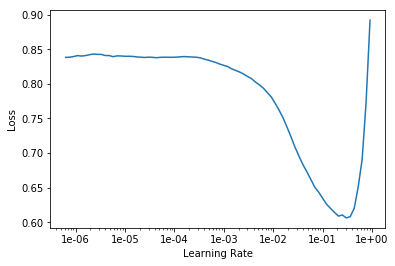

In [7]:
learn.lr_find(); learn.recorder.plot()

In [8]:
lr = 1e-2

In [9]:
learn.fit_one_cycle(6, slice(lr)) # oh cool: fastai by default uses slice(None, 0.003, None) for max_lr

Total time: 05:40
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.120207    0.109189    0.950921         0.902328  (00:55)
2      0.114070    0.102656    0.952287         0.903333  (00:56)
3      0.105674    0.094722    0.956466         0.916477  (00:56)
4      0.102277    0.092419    0.955150         0.916449  (00:56)
5      0.094532    0.088882    0.958762         0.920916  (00:57)
6      0.089107    0.087731    0.959677         0.921157  (00:57)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


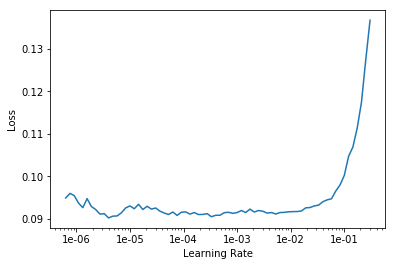

In [10]:
learn.lr_find(); learn.recorder.plot()

In [11]:
learn.save('planet-rn34-sz128-stg1-aggr2')

### size 128 stage 2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


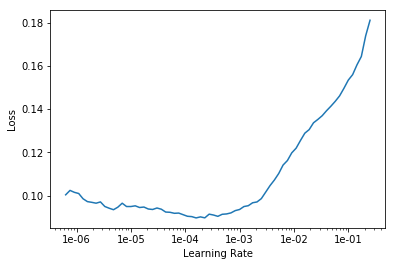

In [12]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

Here I'm looking at using much more aggressive disciminative learning rates. The idea is that satellite imagery is very different from 'real world'-type imagery, so the conv features learned by pretraining on ImageNet aren't going to help as much. That means you want to finetune the earlier conv layer groups of a model more than you normally would.

The idea comes from [my old fastai notebook from 28 Nov 2017](https://github.com/WNoxchi/Kaukasos/blob/master/FADL1/L3CA_lesson2-image-models.ipynb) (which gets it from fastai of that year).

So instead of training at `1e-5, 1.4e-4, 2e-3` like I was up till now (which is what `slice(1e-3, lr/5)` gives you); I'll train at `lr/18, lr/6, lr/2` : `5.6e-4, 1.7e-3, 5e-3`. Each layer group trains at a magnitude-3 offset from the others.

In [13]:
# old d-lr:
learn.lr_range(slice(1e-5, lr/5))

array([1.000000e-05, 1.414214e-04, 2.000000e-03])

In [14]:
# new d-lr:
learn.lr_range(slice(lr/2/9, lr/2)) # lrs: lr/18, lr/6, lr/2; 5.5e-4, 1.6e-3, 5e-3

array([0.000556, 0.001667, 0.005   ])

In [15]:
learn.fit_one_cycle(6, slice(lr/2/9, lr/2)) 

Total time: 08:02
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.107862    0.102498    0.954642         0.909512  (01:20)
2      0.109284    0.107130    0.950093         0.904609  (01:20)
3      0.102715    0.097168    0.955492         0.913619  (01:20)
4      0.098270    0.091129    0.956996         0.921487  (01:20)
5      0.090843    0.085313    0.961654         0.925537  (01:20)
6      0.089074    0.084174    0.962199         0.926292  (01:20)



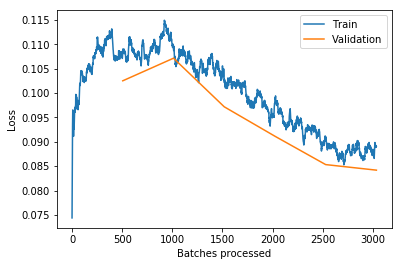

In [16]:
learn.recorder.plot_losses()

In [17]:
learn.save('planet-rn34-sz128-stg2-aggr2')

### size 256 stage 1

In [18]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


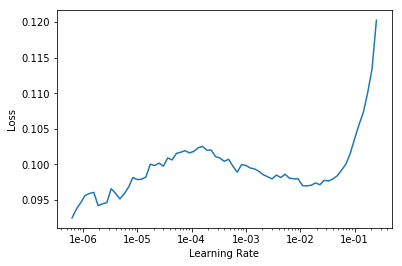

In [19]:
learn.freeze()
learn.lr_find(); learn.recorder.plot()

In [20]:
# lr = 5e-3 # 1e-2/2
lr = 1e-2/2

In [21]:
learn.fit_one_cycle(6, slice(lr))

Total time: 18:25
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.090536    0.088338    0.959998         0.921275  (03:05)
2      0.093259    0.087868    0.959983         0.922321  (03:04)
3      0.091356    0.086231    0.960782         0.924461  (03:04)
4      0.085580    0.085257    0.963841         0.924104  (03:04)
5      0.088625    0.083697    0.962322         0.926626  (03:03)
6      0.087591    0.083884    0.961509         0.926061  (03:04)



In [22]:
learn.save('planet-rn34-sz256-stg1-aggr2')

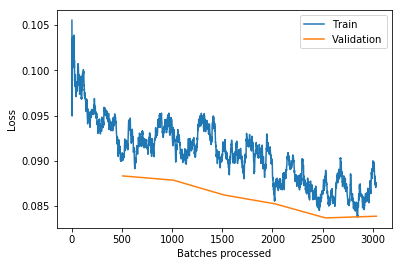

In [23]:
learn.recorder.plot_losses()

### size 256 stage 2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


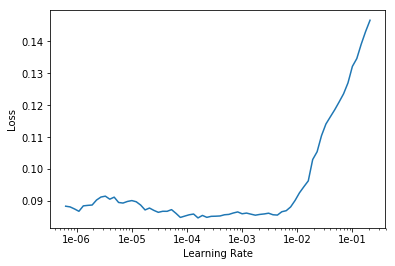

In [24]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [25]:
lr = 1e-3

In [26]:
learn.fit_one_cycle(6, slice(5e-5, lr))

Total time: 25:04
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.086789    0.084348    0.962962         0.924608  (04:09)
2      0.089549    0.083450    0.961785         0.926488  (04:10)
3      0.087171    0.082683    0.961523         0.926531  (04:09)
4      0.085577    0.082934    0.962773         0.926569  (04:12)
5      0.083359    0.082085    0.962708         0.927617  (04:11)
6      0.083386    0.081870    0.962548         0.927831  (04:10)



In [27]:
learn.save('planet-rn34-sz256-stg2-aggr2')

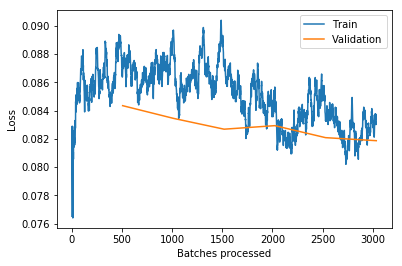

In [28]:
learn.recorder.plot_losses()

(2nd aggr2 run) It's interesting that the validation loss still looks to be on a downward incline. Seems there's more training that could be done.

################################################################################

extra training

In [88]:
learn.load('planet-rn34-sz256-stg2-aggr'); learn.unfreeze()

In [89]:
lr

0.001

In [90]:
learn.fit_one_cycle(6, slice(5e-5/2, lr/2))

Total time: 24:47
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.279129    0.198238    0.895382         0.766065  (04:05)
2      0.113682    0.101499    0.956778         0.913452  (04:08)
3      0.097879    0.092392    0.961436         0.920059  (04:08)
4      0.096557    0.088508    0.961559         0.922773  (04:08)
5      0.095555    0.088310    0.961363         0.923269  (04:08)
6      0.093193    0.087537    0.961610         0.923704  (04:08)



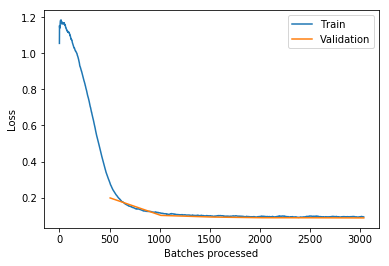

In [91]:
learn.recorder.plot_losses()

In [92]:
learn.save('planet-rn34-sz256-stg2-aggr-extra')

## Predictions

In [37]:
# learn.load('planet-rn34-sz256-stg2-aggr');

In [93]:
subm_df = pd.read_csv(path/'sample_submission_v2.csv')
subdic = {c1:c2 for c1,c2 in zip(subm_df.image_name,subm_df.tags)}

In [94]:
def set_test_datafolder(learner, test_folder):
    learner.data = (src.add_test_folder(test_folder)
                    .transform(tfms, size=256)
                    .databunch().normalize(imagenet_stats))

1st testset portion

In [95]:
set_test_datafolder(learn, 'test-jpg')
fnames = [f.name.split('.')[0] for f in learn.data.test_ds.x.items]

In [96]:
preds1 = learn.TTA(ds_type=DatasetType.Test)

Total time: 12:14



2nd testset portion

In [97]:
set_test_datafolder(learn, 'test-jpg-additional')
fnames.extend([f.name.split('.')[0] for f in learn.data.test_ds.x.items])

In [98]:
preds2 = learn.TTA(ds_type=DatasetType.Test)

Total time: 06:18



In [99]:
preds = (torch.cat((preds1[0],preds2[0])), torch.cat((preds1[1],preds2[1])))

saving results to disk

In [100]:
torch.save(preds, f'planet-rn34-sz256-stg2-aggr-extra.pkl')

In [46]:
# preds = torch.load(f'planet-rn34-sz256-stg2.pkl')

## Submissions

In [101]:
import datetime
date = str(datetime.date.today()).replace('-','')

In [66]:
idx2class = {v:k for k,v in learn.data.c2i.items()}

In [114]:
th = 0.15

for i,fn in enumerate(fnames):
    subdic[fn] = ' '.join(idx2class[cdx] for cdx in np.where(preds[0][i]>=th)[0])
    
subm_col = [subdic[fn] for fn in subm_df.image_name]
subm_df.tags = subm_col

In [115]:
sub_msg = f"fastai {__version__}; rn34 2-stg; aggr-extra; thresh:{th}; {date}"

In [116]:
sub_name = f'planet-rn34-sz256-stg2-aggr-extra_{date}_th{str(th).replace(".","")}.csv'
subm_df.to_csv(path/'submissions/'/sub_name, index=False, )
! kaggle competitions submit -c planet-understanding-the-amazon-from-space -f {path}/submissions/{sub_name} -m "{sub_msg}"

100%|██████████████████████████████████████| 2.29M/2.29M [00:00<00:00, 2.51MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

training for 1 6-length cycle for each stage with 2 sizes (20% val out):

    thres    aggr1  -  aggr2  -  aggr2x
    0.400 - ------- - 0.90992 - -------
    0.350 - ------- - 0.91524 - 0.91519
    0.300 - 0.91920 - 0.91341 - 0.91417
    0.275 - ------- - ------- - -------
    0.250 - 0.92314 - 0.88908 - 0.89742
    0.225 - ------- - ------- - -------
    0.200 - 0.92532 - 0.88367 - 0.88705
    0.180 - 0.92532 - ------- - -------
    0.150 - 0.92428 - ------- - -------

All results @80% train:

threshold| norm1   |  aggr1  |  aggr1x |  aggr2  |  aggr2x
 ------- | ------- | ------- | ------- | ------- | ------- 
   0.400 | ------- | ------- | ------- | 0.90992 | -------
   0.350 | ------- | ------- | 0.91230 | 0.91524 | 0.91519
   0.300 | 0.92206 | 0.91920 | 0.91757 | 0.91341 | 0.91417
   0.250 | 0.92546 | 0.92314 | 0.92074 | 0.88908 | 0.89742
   0.200 | 0.92601 | 0.92532 | 0.92278 | 0.88367 | 0.88705
   0.180 | ------- | 0.92532 | ------- | ------- | -------
   0.150 | 0.92329 | 0.92428 | 0.92210 | 0.92329 | ------- 

Results:

threshold | normal-pvt-score | aggr-1-pvt-score
-|-|-
0.3|0.92206|0.91920
0.25|0.92546|0.92314
0.2|0.92601|0.92532
0.15|0.92329|0.92428

Final metrics:

model|train_loss | valid_loss | accuracy_thresh | fbeta
-|-|-|-|-
norm-1|0.076459  |  0.080886  |  0.964379    |     0.929328
aggr-1|0.086619  |  0.087704  |  0.961886    |     0.926379

Training schedule:

stage|norm-1 6len-cycle dlr|aggr-1 6len-cycle dlr
-|-|-
size128-1|0.01|0.01
size128-2|1e-5, 1.414214e-4, 0.002|5.56e-4, 0.001667, 0.005 
size256-1|0.005|0.01
size256-2|1e-5, 4.472136e-5, 2e-4|1.11e-4, 3.33e-4, 0.001

In [62]:
learn.lr_range(slice(1e-5, 1e-2/5))

array([1.000000e-05, 1.414214e-04, 2.000000e-03])

#### training schedule (text)

---

Model training schedules:
norm-1:

size128 stg1:

    # 1 6-len cycle:
    lr = 1e-2
    learn.lr_range(slice(lr)) = array([0.003333, 0.003333, 0.01    ])
    # frozen: only 0.01 for last layer-group used
    
size128 stg2:

    # 1 6-len cycle:
    learn.lr_range(slice(1e-5,lr/5)) = aarray([1.000000e-05, 1.414214e-04, 2.000000e-03])
    
size256 stg1:

    # 1 6-len cycle:
    lr = 5e-3
    learn.lr_range(slice(lr)) = array([3.333333e-06, 3.333333e-06, 1.000000e-05])
    # frozen: only 1e-5 for last layer-group used
    
size256 stg2:

    # 1 6-len cycle:
    lr = 1e-3
    learn.lr_range(slice(1e-5, lr/5)) = array([1.000000e-05, 4.472136e-05, 2.000000e-04])
    
aggr-1:

size128 stg1:

    # 1 6-len cycle:
    lr = 1e-2
    learn.lr_range(slice(lr)) = array([0.003333, 0.003333, 0.01    ])
    # frozen: only 0.01 for last layer-group used
    
size128 stg2:

    # 1 6-len cycle:
    learn.lr_range(slice(lr/2/9,lr/2)) = array([0.000556, 0.001667, 0.005   ])
    
size256 stg1:

    # 1 6-len cycle:
    lr = 1e-2
    learn.lr_range(slice(lr)) = array([0.003333, 0.003333, 0.01    ])
    # frozen: only 1e-5 for last layer-group used
    
size256 stg2:

    # 1 6-len cycle:
    lr = 1e-3
    learn.lr_range(slice(lr/9, lr)) = array([0.000111, 0.000333, 0.001   ])
    

## end